# **Deep Convolution Adversarial Networks**

# **Loadind and Preprocessing data**

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
import matplotlib.pyplot as plt
import os
from keras import preprocessing
from keras.models import Sequential
from keras.layers import Conv2D,Dropout,Dense,Flatten,Conv2DTranspose,BatchNormalization,LeakyReLU,Reshape
import tensorflow as tf


In [ ]:
import os
cwd = os.getcwd()
os.chdir(cwd)
print(os.listdir("../input"))

In [ ]:
path_celeb = []
train_path_celeb = "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/"
for path in os.listdir(train_path_celeb):
    if '.jpg' in path:
        path_celeb.append(os.path.join(train_path_celeb, path))

In [ ]:
new_path=path_celeb[0:50000]


the dataset have more than 202k images of which only 50k are being selected for the training purpose

In [ ]:
len(new_path)

In [ ]:
crop = (30, 55, 150, 175) #croping size for the image so that only the face at centre is obtained
images = [np.array((Image.open(path).crop(crop)).resize((64,64))) for path in new_path]

for i in range(len(images)):
    images[i] = ((images[i] - images[i].min())/(255 - images[i].min()))
    #images[i] = images[i]*2-1  #uncomment this if activation is tanh for generator last layer
    
images = np.array(images) 

In [ ]:
train_data=images

In [ ]:
len(path_celeb)

In [ ]:
print(train_data.shape)

# **Data Visualization**

In [ ]:
plt.figure(figsize=(10,10))
fig,ax=plt.subplots(2,5)
fig.suptitle("Real Images")
idx=800

for i in range(2):
    for j in range(5):
            ax[i,j].imshow(train_data[idx].reshape(64,64,3))
            #ax[i,j].set_title("Real Image")
            
            idx+=600
            
plt.tight_layout()
plt.show()

**Note**  -- the image pixels are normalized dividing each pixel by 255 and then modified to bring within (-1,1) range by multiplying with 2 and substracting 1 since the last layer activation of generator is tanh whose range limits (-1,1)

In [ ]:
X_train = train_data

# **Architecture of the Model**

The core to the DCGAN architecture uses a standard CNN architecture on the discriminative model. For the generator, convolutions are replaced with upconvolutions, so the representation at each layer of the generator is actually successively larger, as it mapes from a low-dimensional latent vector onto a high-dimensional image.



Use batch normalization in both the generator and the discriminator.

Remove fully connected hidden layers for deeper architectures.

Use ReLU activation in generator for all layers except for the output, which uses Tanh.

Use LeakyReLU activation in the discriminator for all layers.

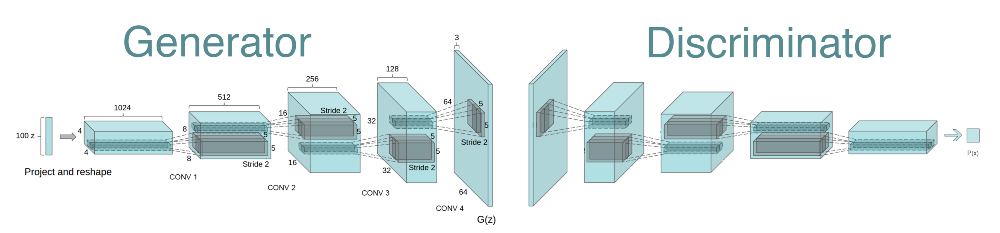

# **Generator**

In [ ]:
noise_shape = 100

In [ ]:
generator=Sequential()
generator.add(Dense(4*4*512,input_shape=[noise_shape]))
generator.add(Reshape([4,4,512]))
generator.add(Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(3, kernel_size=4, strides=2, padding="same",
                                 activation='sigmoid'))

the last layer for generator  have sigmoid activation in this version since I was trying between sigmoid and tanh to see which outputs better results. I found sigmoid activated model having better clarity in this case, however I have tried tanh activated generator too so if anyone want to refer to that can look at version 6/7 of this kernel where I use tanh. In case of using tanh the input pixels should be normalised between (-1,1) unlike sigmoid where it has been normalised between (0,1) .


In [ ]:
generator.summary()

# **Discriminator**

In [ ]:
discriminator=Sequential()
discriminator.add(Conv2D(32, kernel_size=4, strides=2, padding="same",input_shape=[64,64, 3]))
discriminator.add(Conv2D(64, kernel_size=4, strides=2, padding="same"))
discriminator.add(LeakyReLU(0.2))
discriminator.add(BatchNormalization())
discriminator.add(Conv2D(128, kernel_size=4, strides=2, padding="same"))
discriminator.add(LeakyReLU(0.2))
discriminator.add(BatchNormalization())
discriminator.add(Conv2D(256, kernel_size=4, strides=2, padding="same"))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Flatten())
discriminator.add(Dropout(0.5))
discriminator.add(Dense(1,activation='sigmoid'))

In [ ]:
discriminator.summary()

# **DCGAN (combined model)**

In [ ]:
GAN =Sequential([generator,discriminator])

In [ ]:
discriminator.compile(optimizer='adam',loss='binary_crossentropy')
discriminator.trainable = False

In [ ]:
GAN.compile(optimizer='adam',loss='binary_crossentropy')

In [ ]:
GAN.layers

In [ ]:
GAN.summary()

# **Training**

In [ ]:
epochs = 300  #set epoch according to your training dataset size,i had chosen 50k images hence epochs are high as 300...
batch_size = 128

In [ ]:
D_loss=[] #list to collect loss for the discriminator model
G_loss=[] #list to collect loss for generator model

In [ ]:
with tf.device('/gpu:0'):
 for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")
    
    # For every batch in the dataset
    for i in range(X_train.shape[0]//batch_size):
        
        if (i)%100 == 0:
            print(f"\tCurrently on batch number {i} of {len(X_train)//batch_size}")
            
        noise=np.random.uniform(-1,1,size=[batch_size,noise_shape])
        
        gen_image = generator.predict_on_batch(noise)
        
        train_dataset = X_train[i*batch_size:(i+1)*batch_size]
        #train on real image
        train_label=np.ones(shape=(batch_size,1))
        discriminator.trainable = True
        d_loss1 = discriminator.train_on_batch(train_dataset,train_label)
        
        #train on fake image
        train_label=np.zeros(shape=(batch_size,1))
        d_loss2 = discriminator.train_on_batch(gen_image,train_label)
        
        
        noise=np.random.uniform(-1,1,size=[batch_size,noise_shape])
        train_label=np.ones(shape=(batch_size,1))
        discriminator.trainable = False
        #train the generator
        g_loss = GAN.train_on_batch(noise, train_label)
        D_loss.append(d_loss1+d_loss2)
        G_loss.append(g_loss)
        
         
    if epoch % 5 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples,100)))

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(64,64,3))
            plt.xticks([])
            plt.yticks([])

        
        plt.tight_layout()
        plt.show()
    print('Epoch: %d,  Loss: D_real = %.3f, D_fake = %.3f,  G = %.3f' %   (epoch+1, d_loss1, d_loss2, g_loss))        
print('Training is complete')

approx training time for 300 epochs was somthing little more than 2 hours.

# **Output Visualization**

In [ ]:
noise=np.random.uniform(-1,1,size=[500,noise_shape])

In [ ]:
im=generator.predict(noise)

In [ ]:
for i in range(5):
 plt.figure(figsize=(7,7))   
 for k in range(20):
            noise=np.random.uniform(-1,1,size=[100,noise_shape])
            im=generator.predict(noise) 
            plt.subplot(5, 4, k+1)
            plt.imshow(im[k].reshape(64,64,3))
            plt.xticks([])
            plt.yticks([])
 
 plt.tight_layout()
 plt.show()

# **Loss Curve**

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(G_loss,color='red',label='Generator_loss')
plt.plot(D_loss,color='blue',label='Discriminator_loss')
plt.legend()
plt.xlabel('total batches')
plt.ylabel('loss')
plt.title('Model loss per batch')
plt.show()

In [ ]:
import pickle
Pkl_Filename = "DCGAN.pkl"  



# **Reference**

1. https://medium.com/coloredfeather/generating-human-faces-using-adversarial-network-960863bc1deb blog post
2. https://arxiv.org/abs/1511.06434  paper on DCGANS published in 2016


# **Comment if you have any queries or find anything wrong with the code**

# **Upvote if you like the kernel**

# **Thanks**